In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger

In [2]:
# Defining data and labels
# Each spectrum has size 1024x1
data = loadmat('ML_Dataset.mat')
raman_spectra = np.array(data['dataset'])
raman_spectra = np.reshape(raman_spectra.T, (2396, 1024, 1))
labels = np.array(data['labels'])
labels = np.squeeze(labels)

print('Raman spectra data shape:', raman_spectra.shape)
print('Labels data shape:', labels.shape)

print(raman_spectra[5, :, 0])

Raman spectra data shape: (2396, 1024, 1)
Labels data shape: (2396,)
[0.03673262 0.03540598 0.03031812 ... 0.05783042 0.06203714 0.06650225]


In [3]:
# Defining variables
input_shape = (1024,1)
batch_size = 32
epochs = 50
num_classes = 3

model_checkpoint = ModelCheckpoint(filepath='model_checkpoint.h5', monitor='val_loss', save_best_only=True);
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
tensorboard = TensorBoard(log_dir='./logs')
logger = CSVLogger('training.log')
callbacks = [model_checkpoint, early_stopping, tensorboard, logger]

In [4]:
# Split the data into training, validation and testing (70/20/10 split)
X_train, X_test, Y_train, Y_test = train_test_split(raman_spectra, labels, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=1/3, random_state=42)



Y_train = to_categorical(Y_train, num_classes=num_classes)
Y_val = to_categorical(Y_val, num_classes=num_classes)
Y_test = to_categorical(Y_test, num_classes=num_classes)

print('Training data shape:', X_train.shape)
print('Validation data shape:', X_val.shape)
print('Testing data shape:', X_test.shape)


Training data shape: (1677, 1024, 1)
Validation data shape: (479, 1024, 1)
Testing data shape: (240, 1024, 1)


In [5]:
# CNN Model
model = keras.Sequential([
    layers.Conv1D(filters=32, kernel_size=20, activation="relu", input_shape=input_shape),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=20, activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(2048, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax"),
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1005, 32)          672       
                                                                 
 max_pooling1d (MaxPooling1  (None, 502, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 483, 64)           41024     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 241, 64)           0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 15424)             0         
                                                                 
 dense (Dense)               (None, 2048)              3

In [6]:
# Compile Model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [7]:
# Train Model
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, Y_val), shuffle=True, callbacks=callbacks)

Epoch 1/50
53/53 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9881

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 78s 1s/step - loss: 0.0347 - accuracy: 0.9881 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/50
53/53 [==============================] - 57s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/50
53/53 [==============================] - 55s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/50
53/53 [==============================] - 58s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


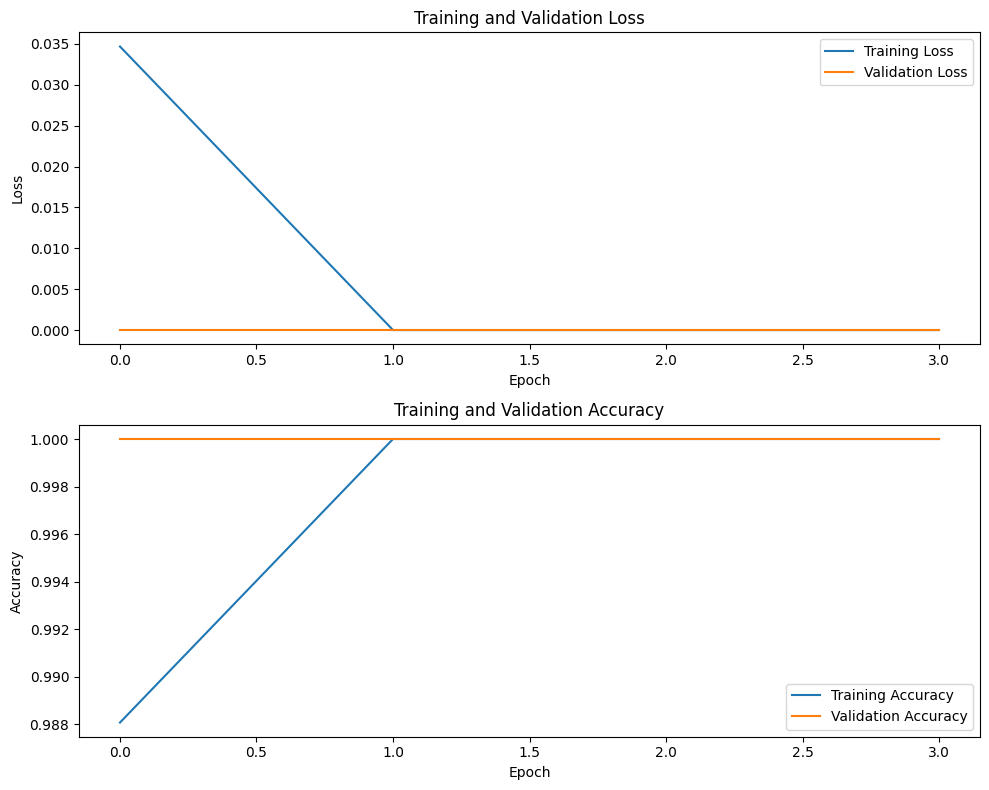

In [8]:
# Plotting the history data from training the model
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plotting training and validation loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plotting training and validation accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [9]:
# Evaluate Model
loss, accuracy = model.evaluate(X_test, Y_test, verbose=1)

print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


8/8 [==============================] - 1s 123ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test loss: 0.0
Test accuracy: 1.0


In [10]:
# Save the model
model.save('CNN_Microplastics.h5')
model.save('CNN_Microplastics.keras')

In [11]:
# Generate predictions for calculating accuracy metrics
Y_pred = model.predict(X_test)
print("predictions shape:", Y_pred.shape)


8/8 [==============================] - 1s 142ms/step
predictions shape: (240, 3)


Confusion Matrix:
[[82  0  0]
 [ 0 88  0]
 [ 0  0 70]]


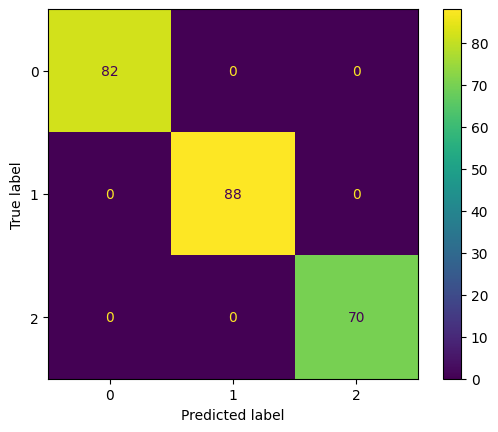

In [12]:
# Converting one-hot encoded predictions into class labels
Y_true_labels = np.argmax(Y_test, axis=1)
Y_pred_labels = np.argmax(Y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_true_labels, Y_pred_labels)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [14]:
# Compute metrics
acc_scr = accuracy_score(Y_true_labels, Y_pred_labels)
print(f'Accuracy Score: {acc_scr}')

# Weighted = Calculate metrics for each label, and find their average weighted by support
sensitivity = recall_score(Y_true_labels, Y_pred_labels,average='weighted')
print(f'Sensitivity : {sensitivity }')

f1 = f1_score(Y_true_labels, Y_pred_labels, average='macro')
print(f'F1-Score: {f1}')

class_names = ['class 0 (PMMA)', 'class 1 (PVC)', 'class 2 (PS)']
print(classification_report(Y_true_labels, Y_pred_labels, target_names=class_names))

Accuracy Score: 1.0
Sensitivity : 1.0
F1-Score: 1.0
                precision    recall  f1-score   support

class 0 (PMMA)       1.00      1.00      1.00        82
 class 1 (PVC)       1.00      1.00      1.00        88
  class 2 (PS)       1.00      1.00      1.00        70

      accuracy                           1.00       240
     macro avg       1.00      1.00      1.00       240
  weighted avg       1.00      1.00      1.00       240



In [15]:
# Testing model on the 60 individually processed spectra
# Defining data and labels
data = loadmat('ML_Data_60_Processed.mat')
raman_spectra = np.array(data['dataset'])
raman_spectra = np.reshape(raman_spectra.T, (60, 1024, 1))
labels = np.array(data['labels'])
Y_true_labels = np.squeeze(labels)

model = load_model('CNN_Microplastics.h5')
Y_pred = model.predict(raman_spectra)

# Converting one-hot encoded predictions into class labels
Y_pred_labels = np.argmax(Y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_true_labels, Y_pred_labels)
print("Confusion Matrix:")
print(cm)

class_names = ['class 0 (PMMA)', 'class 1 (PVC)', 'class 2 (PS)']

print(classification_report(Y_true_labels, Y_pred_labels, target_names=class_names))

2/2 [==============================] - 1s 222ms/step
Confusion Matrix:
[[20  0  0]
 [ 0 20  0]
 [ 0  0 20]]
                precision    recall  f1-score   support

class 0 (PMMA)       1.00      1.00      1.00        20
 class 1 (PVC)       1.00      1.00      1.00        20
  class 2 (PS)       1.00      1.00      1.00        20

      accuracy                           1.00        60
     macro avg       1.00      1.00      1.00        60
  weighted avg       1.00      1.00      1.00        60

